## EDA of international Football Matches

In this notebook we will take a closer look into the evolution of international football matches (i.e. matches played between countries) through the years.

#### Questions to be explored:
- How the international football scenario change over the years?    
    - More games? 
    - Percentage of each continent in the total of games
    - Did the home team used to win more or that value is stable?
    - Teams from different continents play with each other more or less today than they did in the past?
    - Did more different teams win games today than in the past? (não existe mais bobo no futebol)
- How is the performance of a winning world cup team in the years the preceed the tournament?
- How is Brazil comming to this World Cup comparing to the recent World Cups?


#### Columns of results.csv:
- **date**: Date of the match
- **home_team**: Name of the home team
- **away_team**: Name of the away team
- **home_score**: Home team goals
- **away_score**: Away team goals
- **tournament**: Tournament name
- **city**: City where the match took place
- **country**: Country where the match took place.
- **neutral**: Whether the match took place at a neutral venue or not.

In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Start the analysis by reading the results file from the "data" folder
df_results = pd.read_csv("data/results.csv")

# Convert the date column to datetime
df_results['date']  = pd.to_datetime(df_results['date'])

print(f"There are {len(df_results)} matches")
print(f"The first game was {df_results['date'].min().date()} and the last was {df_results['date'].max().date()}")

df_results.head(5)

There are 43752 matches
The first game was 1872-11-30 and the last was 2022-06-14


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [60]:
# Creating some new columns that might be usefull

def get_game_outcome ( home_score, away_score):
    """
    The outcome will be encoded as:
        - D: Draw
        - H: Home team wins
        - A: Away team wins
    """
    if (home_score == away_score):
        return 'D'
    elif (home_score > away_score):
        return 'H'
    elif (home_score < away_score):
        return 'A'

def winning_team(home_team, away_team, outcome):
    if (outcome == 'H'):
        return home_team
    elif (outcome == 'A'):
        return away_team
    else:
        return '-'

def losing_team(home_team, away_team, outcome):
    if (outcome == 'A'):
        return home_team
    elif (outcome == 'H'):
        return away_team
    else:
        return '-'

# The outcome of the game
df_results['outcome'] = df_results.apply(lambda x: get_game_outcome(x.home_score, x.away_score), axis=1)

# Name of the winning team
df_results['winning_team'] =  df_results.apply(lambda x: winning_team(x.home_team, x.away_team, x.outcome), axis=1)

# Name of the losing team
df_results['losing_team'] =  df_results.apply(lambda x: losing_team(x.home_team, x.away_team, x.outcome), axis=1)

# Score difference
df_results['score_difference'] = df_results.apply(lambda x: abs(x.home_score - x.away_score), axis=1)

# Teams envolved on the match
df_results['teams_envolved'] = df_results.apply(lambda x: [x.home_team, x.away_team], axis = 1)

# Year of the game
df_results['year'] = df_results['date'].apply(lambda x: x.year)

# Month of the game
df_results['month'] = df_results['date'].apply(lambda x: x.month_name())

# Day of the game
df_results['day'] = df_results['date'].apply(lambda x: x.day)

# Day of the week of the game
df_results['day_name'] = df_results['date'].apply(lambda x: x.day_name())

# The home team actually play at home?
df_results['home_playing_home'] = df_results.apply(lambda x: 'y' if x.home_team == x.country else 'n', axis = 1)

In [61]:
df_geo_regions = pd.read_csv('data/geographic-regions.csv')
df_geo_regions.fillna('-', inplace = True)
df_geo_regions.rename(columns = {'Country or Area':'country_reff', 'Region Name':'continent'}, inplace = True)

missing_countries_dict = {
                            'England':'Europe',
                            'Scotland':'Europe',
                            'Wales':'Europe',
                            'Turkey':'Europe',
                            'Tanzania':'Africa',
                            'China PR':'Asia',
                            'Republic of Ireland':'Europe',
                            'Iran':'Asia',
                            'Northern Ireland':'Europe',
                            'Russia':'Europe',
                            'Ivory Coast':'Africa',
                            'Yugoslavia':'Europe',
                            'Hong Kong':'Asia',
                            'Bolivia':'Americas',
                            'Czechoslovakia':'Europe',
                            'Venezuela':'Americas',
                            'Soviet Union':'Europe',
                            'Czech Republic':'Europe',
                            'Vietnam':'Asia',
                            'German DR':'Europe',
                            'Syria':'Asia',
                            'Malaya':'Asia',
                            'Moldova':'Europe',
                            'DR Congo':'Africa',
                            'Cape Verde':'Africa',
                            'Netherlands Antilles':'Americas',
                            'Vietnam Republic':'Asia',
                            'Zaïre':'Africa',
                            'Taiwan':'Asia',
                            'Laos':'Asia'
}

def get_continent ( label, df_results ):
    df_merged = df_results.merge(df_geo_regions[['country_reff','continent']], how = 'left', left_on =label, right_on = 'country_reff')
    df_merged['continent'] = df_merged['continent'].fillna('-')
    return df_merged.apply(lambda x: missing_countries_dict.get(x[label], "not found") if x.continent == '-' else x.continent, axis=1 )

# Get the continent of the game, the away_team and the home_team
df_results['game_continent'] = get_continent ( 'country', df_results )
df_results['home_team_continent'] = get_continent ( 'home_team', df_results )
df_results['away_team_continent'] = get_continent ( 'away_team', df_results )

# The home team is playing in their continent?
df_results['home_playing_continent'] = df_results.apply(lambda x: 'y' if x.home_team_continent == x.game_continent else 'n', axis = 1)

# The away team is playing in their continent?
df_results['away_playing_continent'] = df_results.apply(lambda x: 'y' if x.away_team_continent == x.game_continent else 'n', axis = 1)

# Both of the teams are from the same continent?
df_results['same_continent'] = df_results.apply(lambda x: 'y' if x.away_team_continent == x.home_team_continent else 'n', axis = 1)

# Continents envolved on the match
df_results['continents_envolved'] = df_results.apply(lambda x: [x.home_team_continent, x.away_team_continent], axis = 1)

#df_merged[df_merged['Region Name'].isna() == True]['country'].value_counts().head(50)

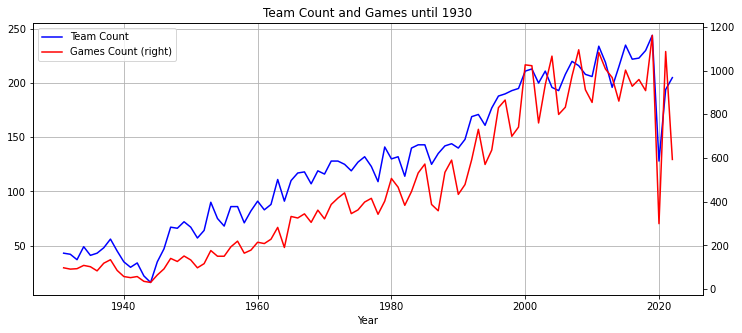

In [51]:
# Count how many different teams played international matches in each year
df_filtered = df_results[df_results['year'] > 1930]

list_team_count = []
for y in df_filtered['year'].unique():
    matches_list = df_filtered.groupby(by = 'year').get_group(y)['teams_envolved'].to_list()
    countries = [m[0] for m in matches_list] # Gets the home team
    countries.extend([m[1] for m in matches_list]) # Gets the away team
    list_team_count.append(len(set(countries)))

series_team_count = pd.Series(index=df_filtered['year'].unique(), data=list_team_count)
series_game_count = df_filtered['year'].value_counts(sort = False)


plt.figure(figsize=(12,5))
plt.xlabel('Year')
plt.title("Team Count and Games until 1930")

ax1 = series_team_count.plot(color='blue', grid=True, label='Team Count')
ax2 = series_game_count.plot(color='red', grid=True, secondary_y=True, label='Games Count')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

<AxesSubplot:title={'center':'Percentage of games for continent'}>

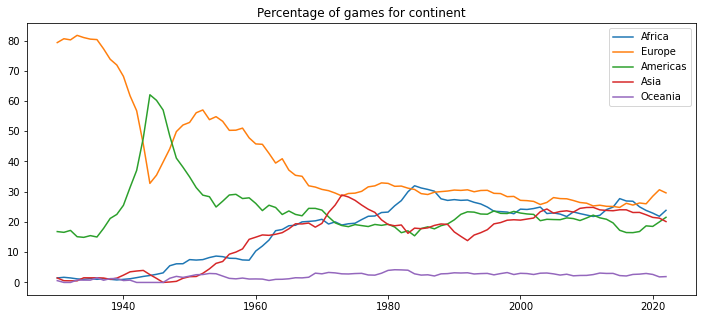

In [107]:
# What percentage of teams each continent had over the years
df_filtered = df_results[df_results['year'] > 1926]


list_continent_count = []
for y in df_filtered['year'].unique():
    matches_list = df_filtered.groupby(by = 'year').get_group(y)['continents_envolved'].to_list()
    continents = [m[0] for m in matches_list] # Gets the home team continent
    continents.extend([m[1] for m in matches_list]) # Gets the away team continent
    # Count of many of each continent we have
    africa = len([a for a in continents if a == 'Africa'])
    europe = len([a for a in continents if a == 'Europe'])
    americas = len([a for a in continents if a == 'Americas'])
    asia = len([a for a in continents if a == 'Asia'])
    oceania = len([a for a in continents if a == 'Oceania'])
    not_found = len([a for a in continents if a == 'not found'])

    list_continent_count.append([africa, europe, americas, asia, oceania, not_found])

df_contient_count = pd.DataFrame(index=df_filtered['year'].unique(), 
                                data=list_continent_count, 
                                columns = ['Africa', 'Europe', 'Americas', 'Asia', 'Oceania', 'not found'])

# Sum to get the total for each year
df_contient_count['total'] = df_contient_count.sum(axis=1)

# Calculate the roling mean of 4 years to have a smoother plot
df_contient_count = df_contient_count.rolling(4).mean().dropna()

# Calculate the percentage for each year
for c in [c for c in df_contient_count.columns if c != 'total']:
    df_contient_count[c] = df_contient_count.apply(lambda x: round(100*(x[c]/x['total']),2), axis = 1)


df_contient_count[['Africa', 'Europe', 'Americas', 'Asia', 'Oceania']].plot(figsize=(12,5),
                                                                            title = "Percentage of games for continent")

<AxesSubplot:title={'center':'Percentage of matches with different countries teams'}>

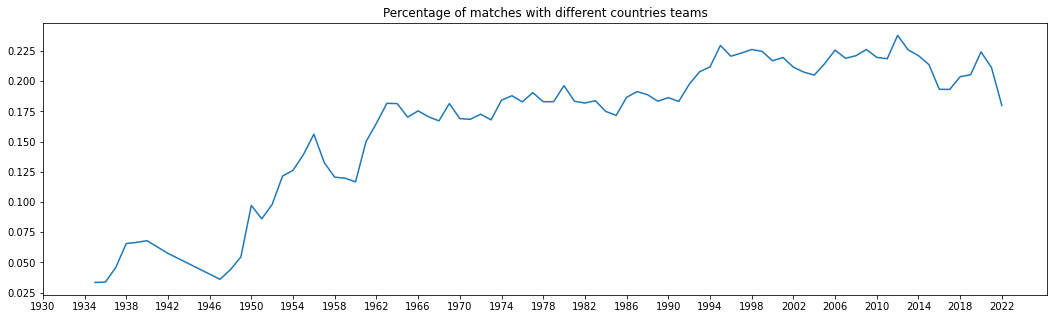

In [126]:
# Teams from diffent continent play with each other more or less they did in the past
# Count how many different teams played international matches in each year
df_filtered_continent = df_results[(df_results['year'] > 1930) & (df_results['same_continent'] == 'n')]
df_filtered = df_results[df_results['year'] > 1930]

series_diff_continents_count = df_filtered_continent['year'].value_counts(sort = False)
series_game_count = df_filtered['year'].value_counts(sort = False)

# Plot the rolling mean to get a smoother value
xticks_values = np.arange(1930, 2026, 4).tolist()
(series_diff_continents_count/series_game_count).dropna().rolling(4).mean().dropna().plot(figsize=(18,5),
                                                                                          title = "Percentage of matches with different countries teams",
                                                                                          xticks = xticks_values)

In [127]:
# European and American teams now play less with different continents


In [72]:
# Get a dictionary that has the Country names as Keys and the Continent as Values

total_unique_countries = pd.concat([df_results['home_team'], df_results['away_team']]).unique()

dict_country_continent = {}
for c in total_unique_countries:
    try: 
        dict_country_continent[c] = df_results[df_results['home_team'] == c]['home_team_continent'].unique()[0]
    except:
        # If the team never had a game playing home
        dict_country_continent[c] = df_results[df_results['away_team'] == c]['away_team_continent'].unique()[0]